# Figure 9 : Spatial projections
conda env: `phd_v3` (in `envs/phd`)

In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [3]:
period_past = slice('1995','2014')
period_future = slice('2081','2100')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

list_var = ['tas', 'snc', 'pr']

## Load topography

In [4]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

# If no modification possible to load results: [#Load-results](#Load-results)

## Load models

### Initialize Dataset to store results

In [106]:
list_models = u.get_model_names_projections()
experiments = ['hist', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
dims = ['lat', 'lon', 'season', 'experiment', 'model']

init = np.empty((
    elevation.sel(lat=latlim, lon=lonlim).lat.size,
    elevation.sel(lat=latlim, lon=lonlim).lon.size,
    len(seasons),
    len(experiments),
    len(list_models)
))
init[:] = np.nan

ds_results = xr.Dataset(
    {
        'tas': (dims, init),
        'snc': (dims, init),
        'pr': (dims, init),
    },
    coords={
        'lat': elevation.sel(lat=latlim, lon=lonlim).lat,
        'lon': elevation.sel(lat=latlim, lon=lonlim).lon,
        'season': seasons,
        'experiment': experiments,
        'model': list_models
    },
)
ds_results

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, model: 10, season: 3)
Coordinates:
  * lat         (lat) float32 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float32 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) <U6 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) <U6 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * model       (model) <U13 'BCC-CSM2-MR' 'CNRM-CM6-1' ... 'UKESM1-0-LL'
Data variables:
    tas         (lat, lon, season, experiment, model) float64 nan nan ... nan
    snc         (lat, lon, season, experiment, model) float64 nan nan ... nan
    pr          (lat, lon, season, experiment, model) float64 nan nan ... nan

In [107]:
%%time

list_models = u.get_model_names_projections()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

for var in list_var:
    table = u.get_table(var)
    label, units, levels, cmap, extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    print(label)
    
    resolution = [None]*len(list_models)

    da_past_clim_list = [[None] * (len(list_models)) for i in range(len(seasons))]

    scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
    da_ssp126_clim_list = [[None] * (len(list_models)) for i in range(len(seasons))]
    da_ssp245_clim_list = [[None] * (len(list_models)) for i in range(len(seasons))]
    da_ssp370_clim_list = [[None] * (len(list_models)) for i in range(len(seasons))]
    da_ssp585_clim_list = [[None] * (len(list_models)) for i in range(len(seasons))]

    da_future_clim_list = [da_ssp126_clim_list, da_ssp245_clim_list, da_ssp370_clim_list, da_ssp585_clim_list]


    for i, model in enumerate(list_models):
        print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
        institute, grid, realization, calendar = u.get_model_infos(model, var)

        #################
        ### Load past ###
        #################
        da_past = xr.open_mfdataset(
            '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
            combine='by_coords').sel(time=period_past, lat=latlim_ext, lon=lonlim_ext)[var]

        np.testing.assert_equal((int(period_past.stop) - int(period_past.start) + 1)*12, da_past.time.size)

        #################################################################################

        if var == 'tas':
            da_past -= 273.15
        elif var == 'snc':
            if da_past.max().values <= 1.1:
                da_past = da_past*100
            da_past = da_past.where( (da_past >= -0.1) & (da_past <= 100.1) )
        elif var == 'pr':
            da_past = da_past * 86400

        #################################################################################


        # Print resolution and save it
        lat = (da_past.lat[1] - da_past.lat[0]).values; lon = (da_past.lon[1] - da_past.lon[0]).values
        print(str(lon.round(3))+'°x'+str(lat.round(3))+'°')
        resolution[i] = str(lon.round(1))+'°x'+str(lat.round(1))+'°'

        for k, season in enumerate(seasons):
            # Make year_mean
            da_past_clim = u.clim(da_past, calendar=calendar, season=season)

            # Regrid
            regridder = xe.Regridder(da_past_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
            da_past_clim_regrid = regridder(da_past_clim)

            # Store result
            da_past_clim_list[k][i] = da_past_clim_regrid.load()




        ###################
        ### Load future ###
        ###################
        for j, scenario in enumerate(scenarios):
            if model in ['IPSL-CM6A-LR', 'MRI-ESM2-0']:
                da_future = xr.open_mfdataset(
                    '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*210012.nc', 
                    combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]
            else:
                da_future = xr.open_mfdataset(
                    '/bdd/CMIP6/ScenarioMIP/'+institute+'/'+model+'/'+scenario+'/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
                    combine='by_coords').sel(time=period_future, lat=latlim_ext, lon=lonlim_ext)[var]

            np.testing.assert_equal((int(period_future.stop) - int(period_future.start) + 1)*12, da_future.time.size)


            #################################################################################

            if var == 'tas':
                da_future -= 273.15
            elif var == 'snc':
                if da_future.max().values <= 1.1:
                    da_future = da_future*100
                da_future = da_future.where( (da_future >= -0.1) & (da_future <= 100.1) )
            elif var == 'pr':
                da_future = da_future * 86400

            #################################################################################

            for k, season in enumerate(seasons):
                # Make year_mean
                da_future_clim = u.clim(da_future, calendar=calendar, season=season)

                # Regrid
                da_future_clim_regrid = regridder(da_future_clim)

                # Store result
                da_future_clim_list[j][k][i] = da_future_clim_regrid.load()

        print('\n')
        
    #######################
    # Concatenate results #
    #######################
    
    # Model past
    temp = [None]*len(seasons)
    for k, season in enumerate(seasons):
        temp[k] = xr.concat(
            da_past_clim_list[k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
        )
    mm_past = xr.concat(temp, pd.Index(seasons, name="season"))    
    
    # Model future
    temp_scenarios = [None]*len(scenarios)

    for j, scenario in enumerate(scenarios):
        temp = [None]*len(seasons)
        for k, season in enumerate(seasons):
            temp[k] = xr.concat(
                da_future_clim_list[j][k][:], pd.Index(list_models, name='model'), coords='minimal', compat='override'
            )
        temp_scenarios[j] = xr.concat(temp, pd.Index(seasons, name="season")).load()
        
    temp_scenarios.insert(0, mm_past)

    ds_results[var] = xr.concat(temp_scenarios, pd.Index(experiments, name="experiment")).load()

Near-Surface Air Temperature
BCC-CSM2-MR (1/10)
1.125°x1.121°
Reuse existing file: bilinear_32x54_35x60.nc
Reuse existing file: bilinear_32x54_35x60.nc
Reuse existing file: bilinear_32x54_35x60.nc


CNRM-CM6-1 (2/10)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc
Reuse existing file: bilinear_25x42_35x60.nc
Reuse existing file: bilinear_25x42_35x60.nc


CNRM-CM6-1-HR (3/10)
0.5°x0.499°
Reuse existing file: bilinear_70x121_35x60.nc
Reuse existing file: bilinear_70x121_35x60.nc
Reuse existing file: bilinear_70x121_35x60.nc


CNRM-ESM2-1 (4/10)
1.406°x1.401°
Reuse existing file: bilinear_25x42_35x60.nc
Reuse existing file: bilinear_25x42_35x60.nc
Reuse existing file: bilinear_25x42_35x60.nc


CanESM5 (5/10)
2.812°x2.791°
Reuse existing file: bilinear_13x21_35x60.nc
Reuse existing file: bilinear_13x21_35x60.nc
Reuse existing file: bilinear_13x21_35x60.nc


IPSL-CM6A-LR (6/10)
2.5°x1.268°
Reuse existing file: bilinear_28x25_35x60.nc
Reuse existing file: bilinear_28x25_35x60.nc
R

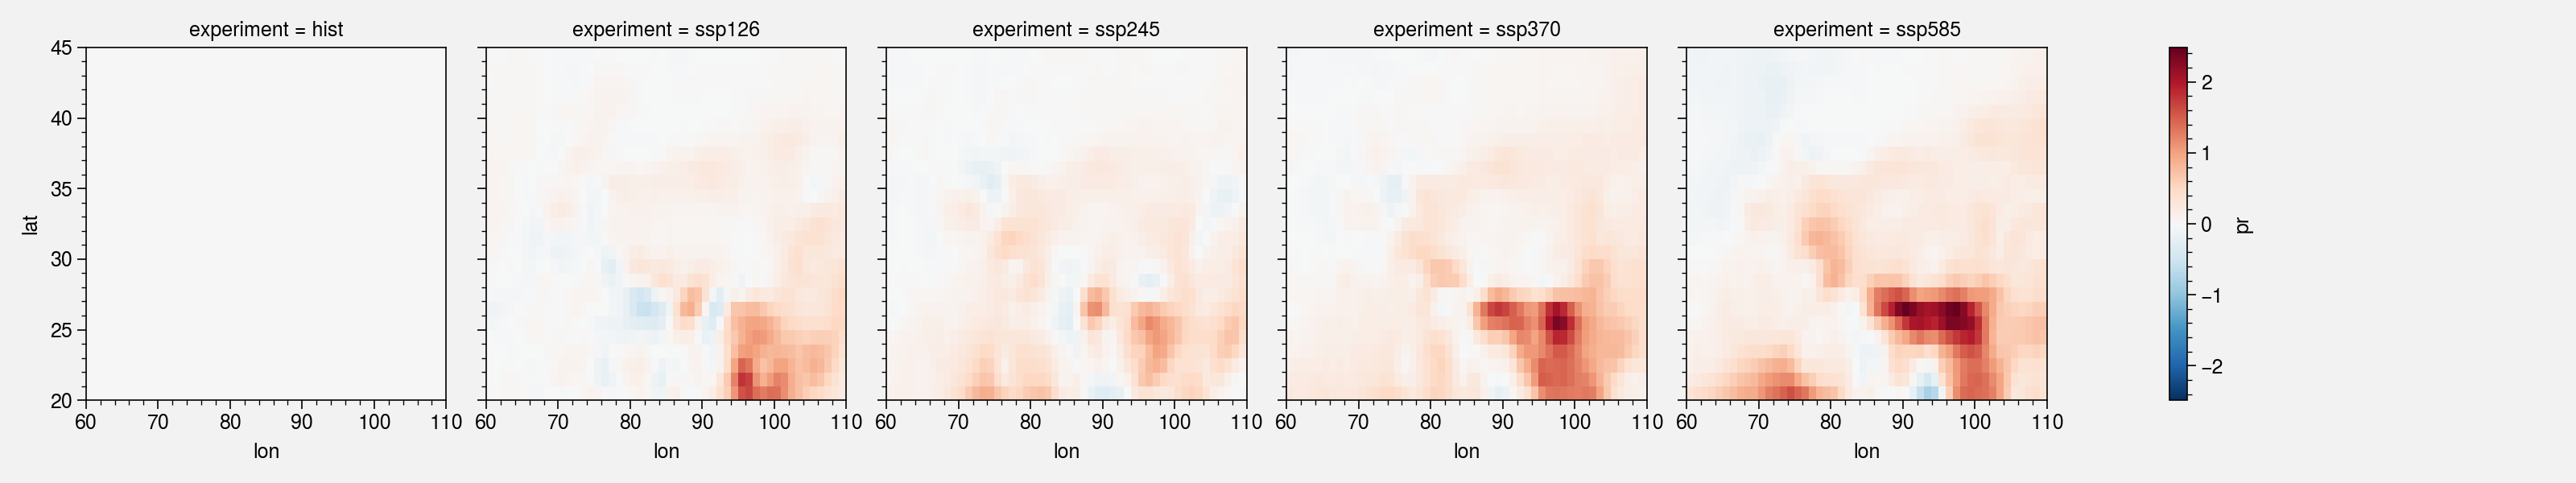

In [104]:
# (ds_results.pr.isel(model=0) - ds_results.pr.isel(model=0, experiment=0)).isel(season=0).plot(col='experiment')

## Save results

In [119]:
ds_results.to_netcdf('results/HMA_spatial_projections_'+period_past.start+'-'+period_past.stop+'_'+period_future.start+'-'+period_future.stop+'.nc')

## Load results

In [5]:
ds_results = xr.open_dataset('results/HMA_spatial_projections_'+period_past.start+'-'+period_past.stop+'_'+period_future.start+'-'+period_future.stop+'.nc')
ds_results

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, model: 10, season: 3)
Coordinates:
  * lat         (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float64 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) object 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) object 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * model       (model) object 'BCC-CSM2-MR' 'CNRM-CM6-1' ... 'UKESM1-0-LL'
    height      float64 ...
Data variables:
    tas         (experiment, season, model, lat, lon) float64 ...
    snc         (experiment, season, model, lat, lon) float64 ...
    pr          (experiment, season, model, lat, lon) float64 ...

## Plot

In [6]:
anomalies = ds_results - ds_results.sel(experiment='hist')

In [7]:
median = anomalies.median('model')
median

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, season: 3)
Coordinates:
  * lat         (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float64 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) object 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) object 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
    height      float64 2.0
Data variables:
    tas         (experiment, season, lat, lon) float64 0.0 0.0 ... 6.933 6.904
    snc         (experiment, season, lat, lon) float64 0.0 0.0 ... -0.003262
    pr          (experiment, season, lat, lon) float64 0.0 0.0 ... 0.1447 0.1473

In [8]:
quantiles = anomalies.quantile([0.05, 0.95], dim='model')
quantiles

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, quantile: 2, season: 3)
Coordinates:
  * lat         (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float64 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) object 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) object 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * quantile    (quantile) float64 0.05 0.95
Data variables:
    tas         (quantile, experiment, season, lat, lon) float64 0.0 ... 8.49
    snc         (quantile, experiment, season, lat, lon) float64 0.0 0.0 ... 0.0
    pr          (quantile, experiment, season, lat, lon) float64 0.0 ... 0.8058

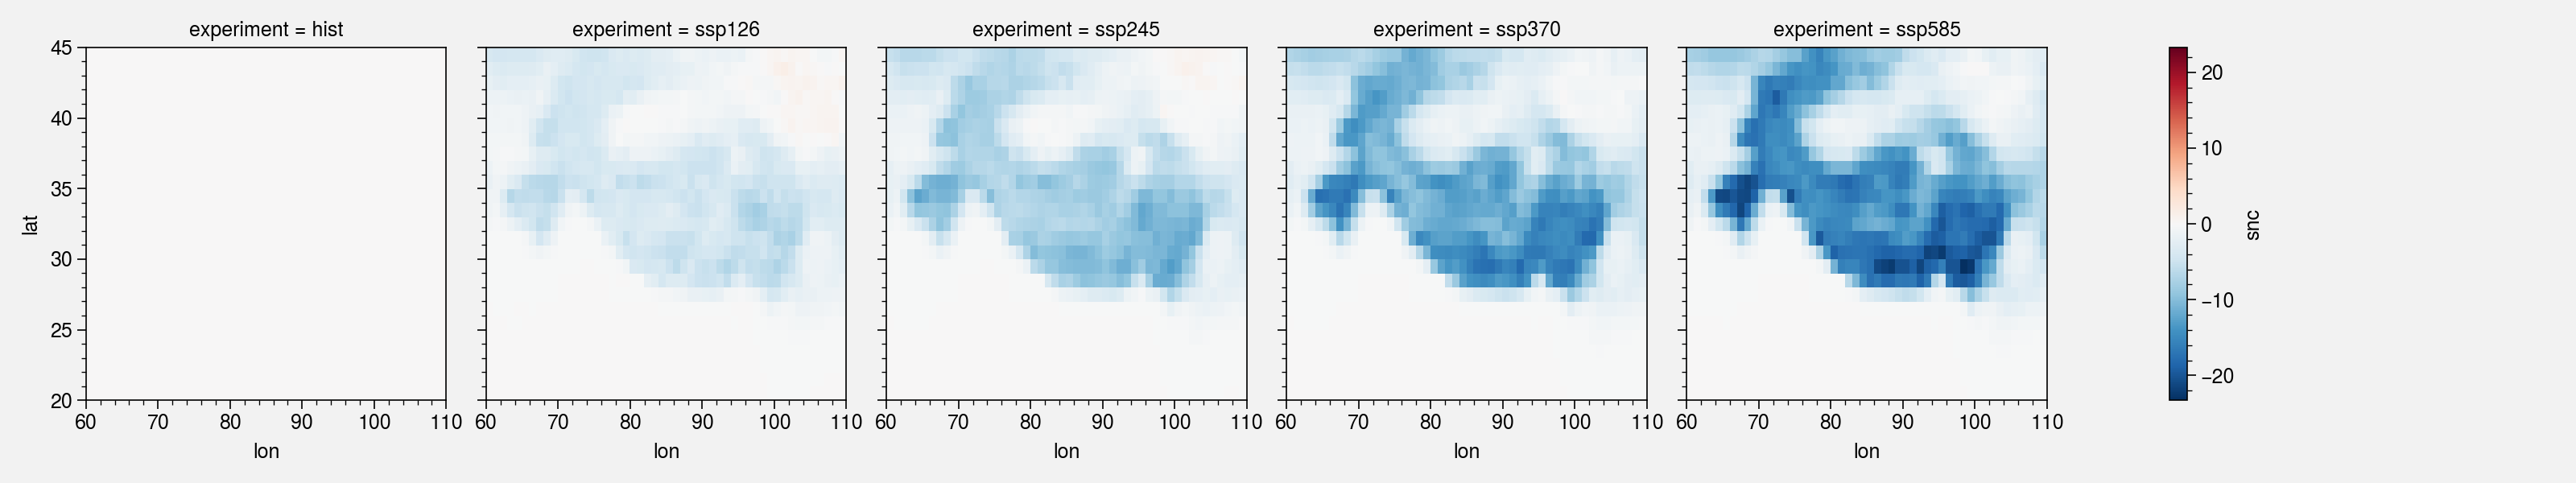

In [13]:
median.isel(season=0).snc.plot(col='experiment')

## Absolute anomalies

## Shows only seasonal ssp245 and ss370

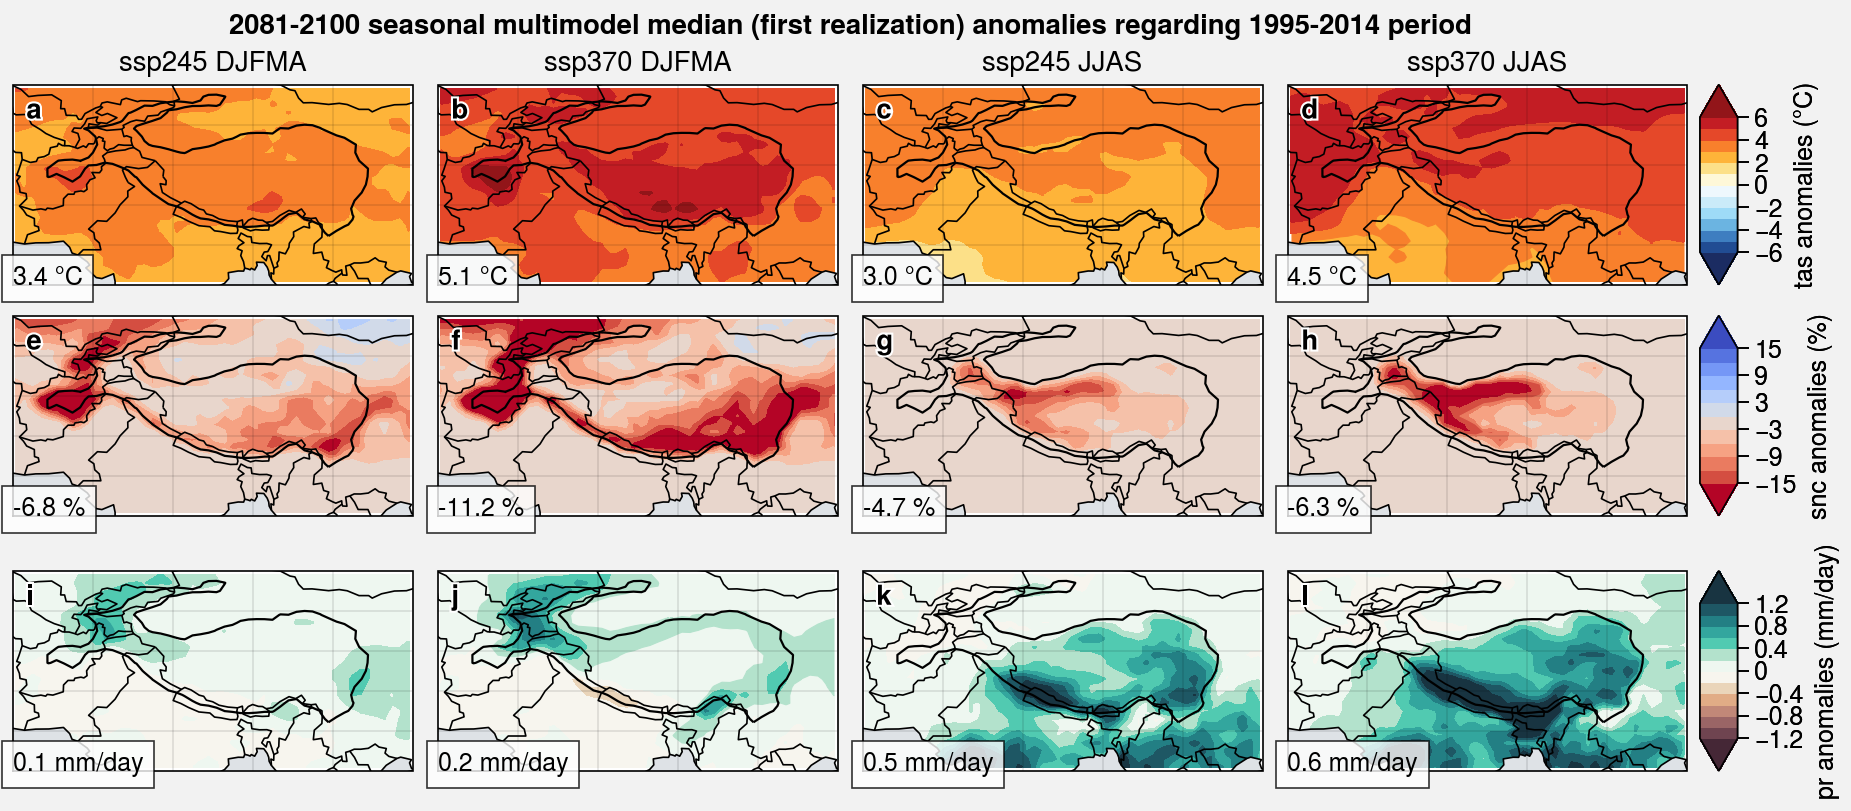

In [32]:
cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
levels_list = [plot.arange(-6,6,1), plot.arange(-15,15,3), plot.arange(-1.2,1.2,0.2)]
extend_list = ['both', 'both', 'both']
experiments = ['ssp245', 'ssp370']

facecolor = 'white'
alpha = 0.8

f, axs = plot.subplots(proj='cyl', ncols=len(experiments)*2, nrows=len(list_var), axwidth=2)
k = 0

for i_var, var in enumerate(list_var):

    label, units, levels, cmap, extend, \
            levels_diff, cmap_diff, extend_diff, \
            levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
    for season in seasons[1:]:

        for experiment in experiments:
            m = axs[k].contourf(
                median.sel(season=season, experiment=experiment)[var], cmap=cmap_list[i_var], levels=levels_list[i_var], extend=extend_list[i_var]
            )
            if k in range(len(experiments)*2):
                axs[k].format(title=experiment + ' ' + season)
            
            # Add mean values over HMA
            a = u.spatial_average(
                median.sel(
                    season=season, 
                    experiment=experiment, 
                    lat=zones_df.loc['HMA', 'latlim'],
                    lon=zones_df.loc['HMA', 'lonlim']
                ).where(elevation > 2500)[var]
            ).values
            
            axs[k].text(
                60, 20, 
                '{:.1f}'.format(round(a.item(0), 2)) + ' '+units,
                bbox=dict(facecolor=facecolor, alpha=alpha)
            )    
            
            k += 1

    axs[k-1].colorbar(m, label=var+' anomalies ('+units+')')

for ax in axs:
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

axs.format(
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=period_future.start+'-'+period_future.stop+ ' seasonal multimodel median (first realization) anomalies regarding '+period_past.start+'-'+period_past.stop+' period',
    abc=True, abcloc='ul'
)

filename = 'fig9_spatial-projections_seasonal'
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Show all

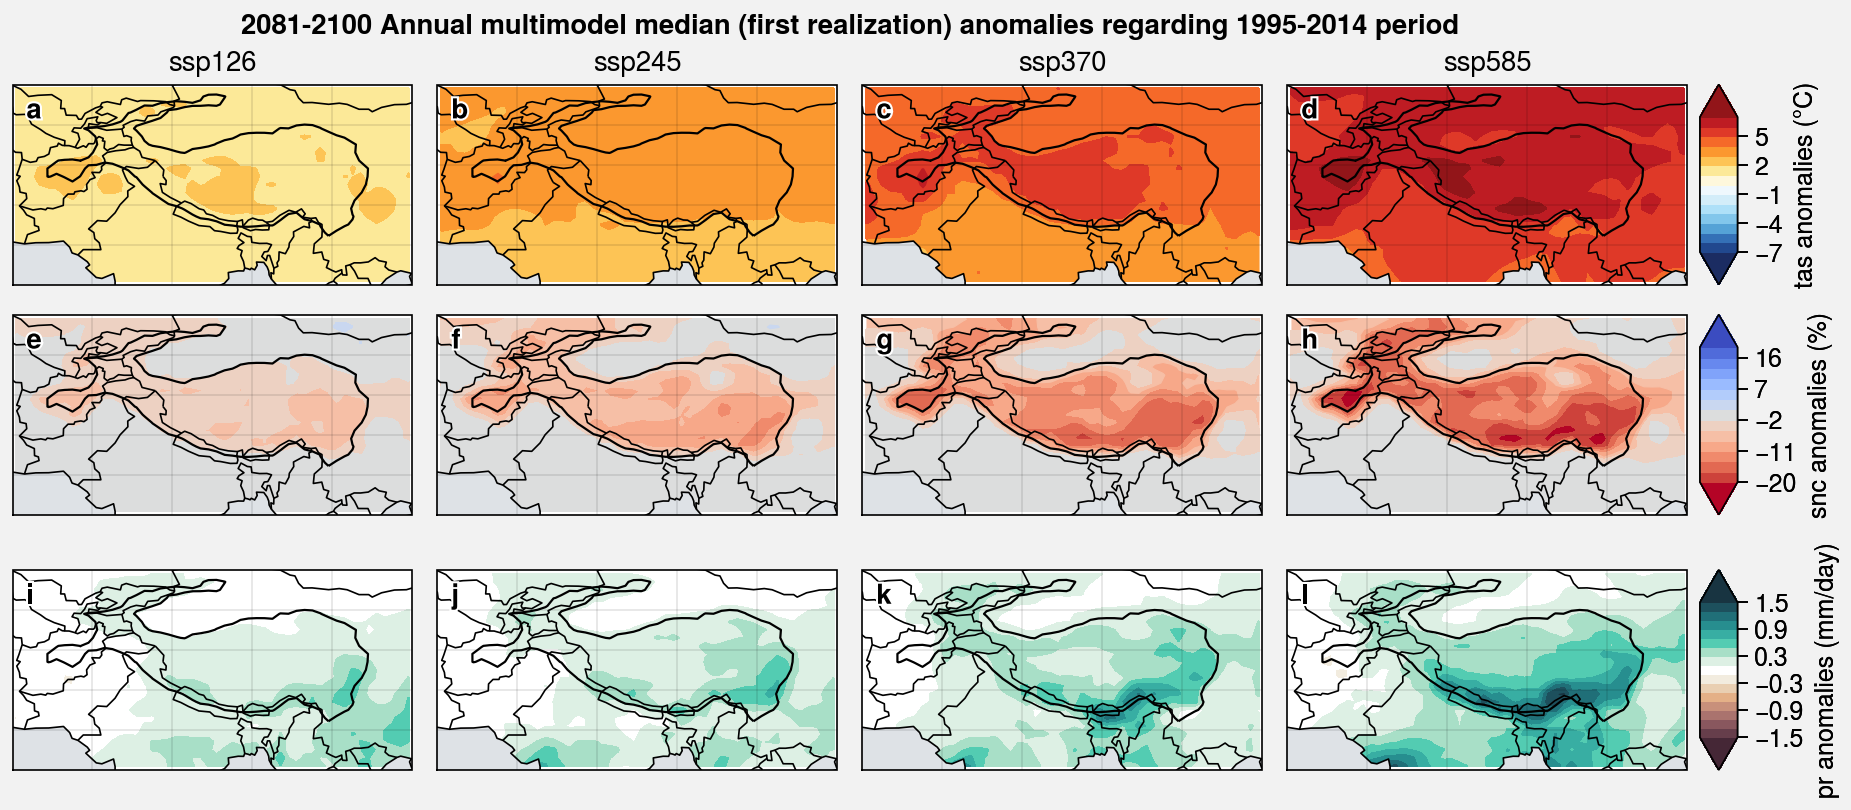

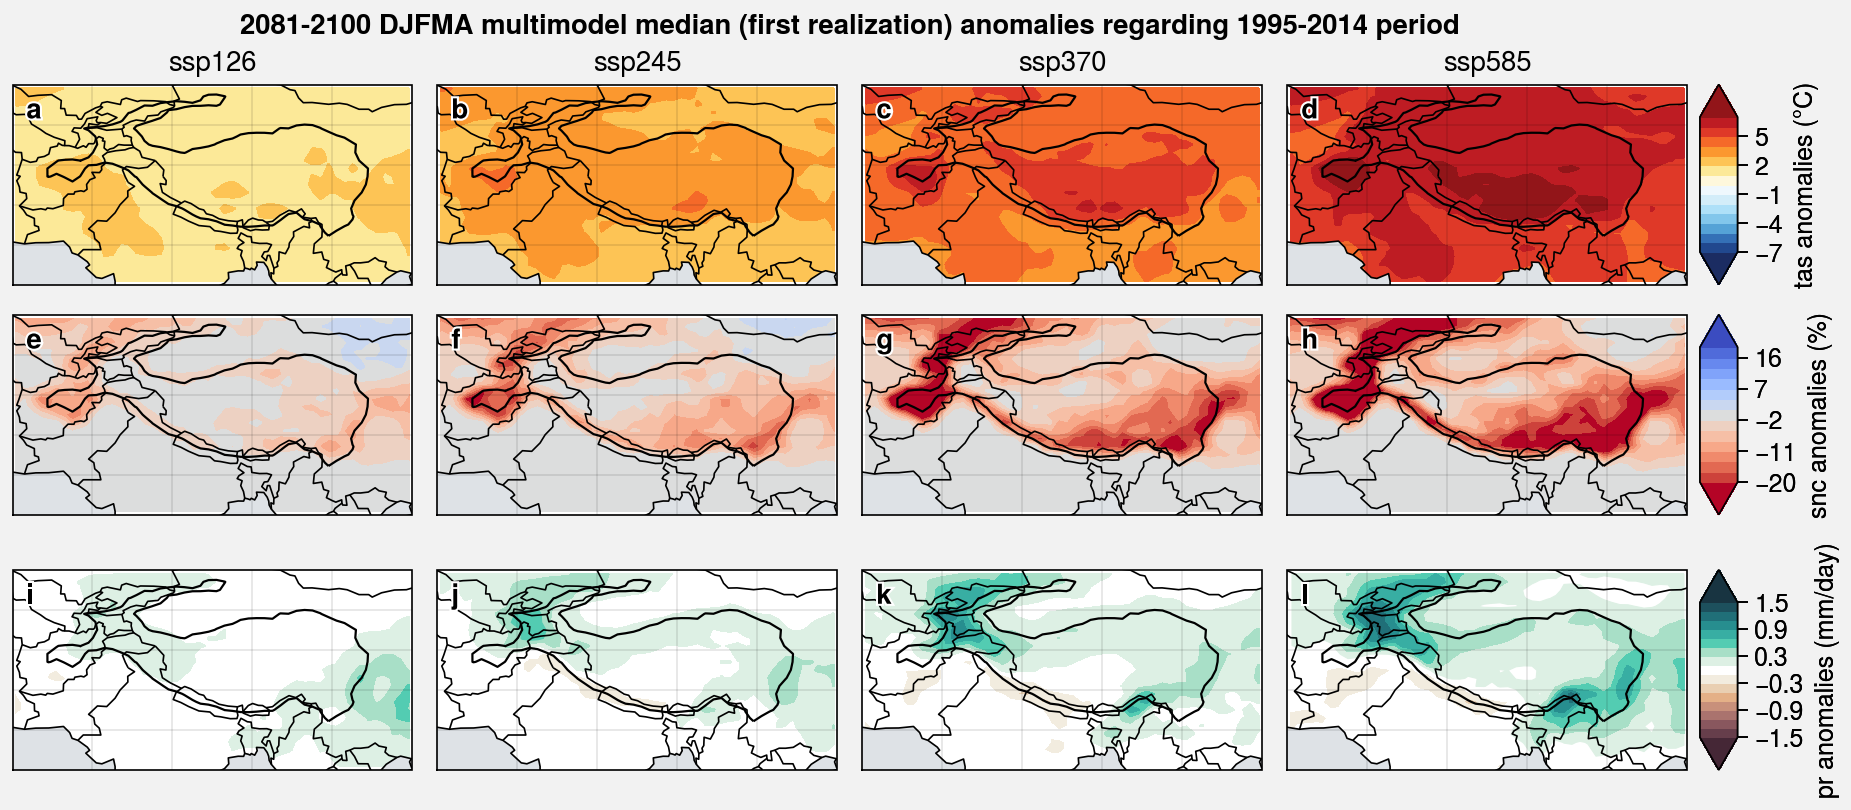

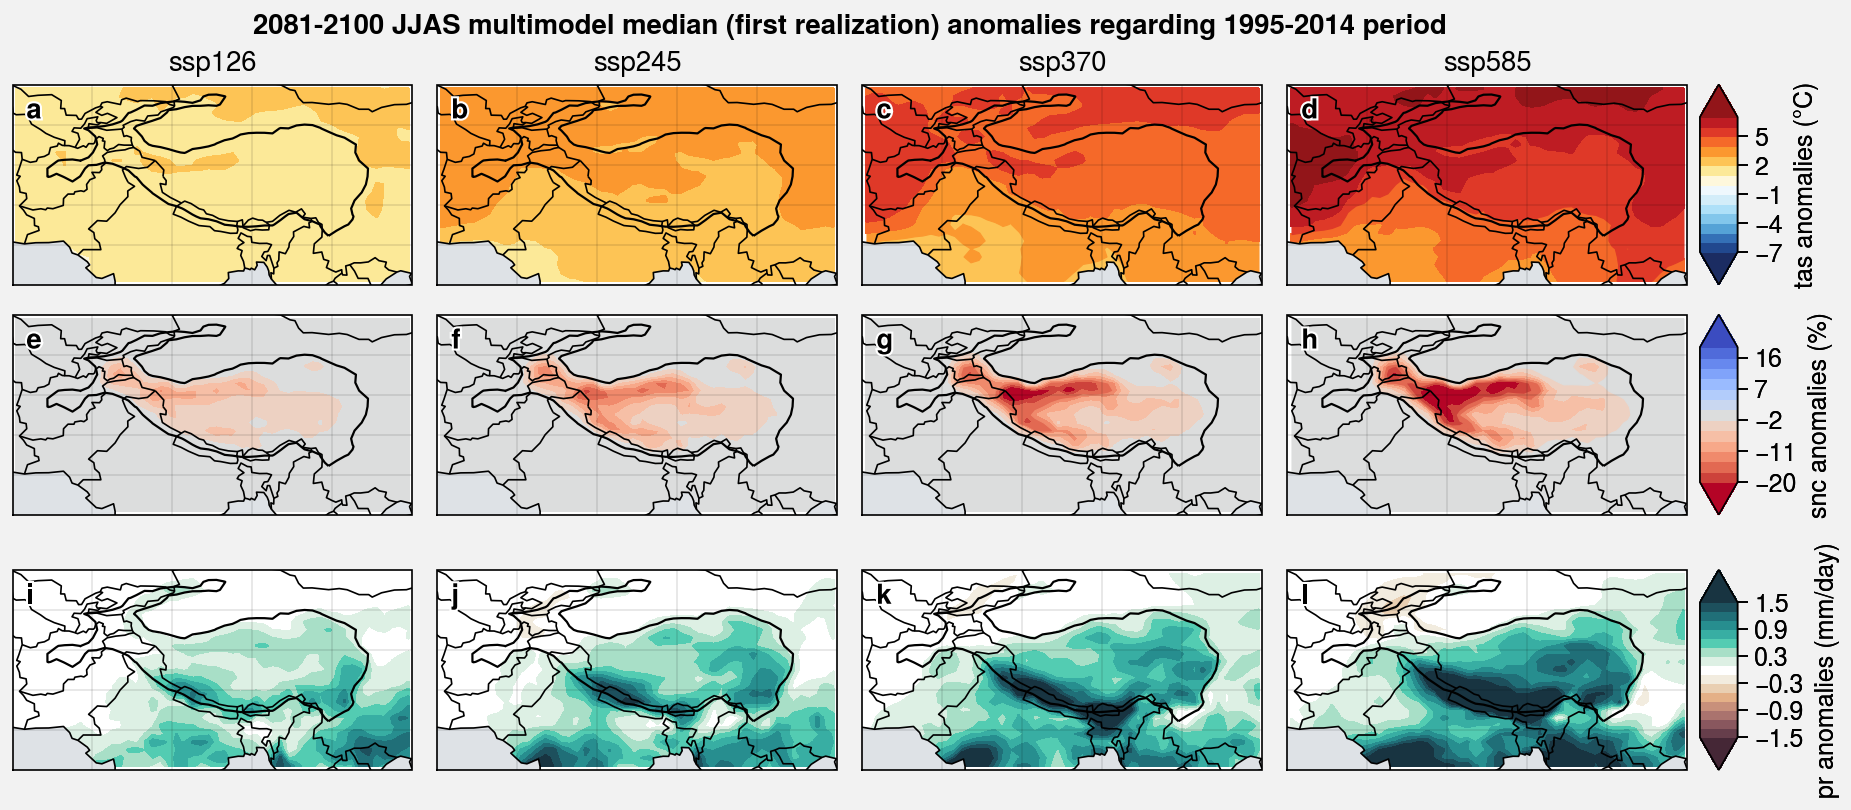

In [31]:
cmap_list = ['ColdHot', 'CoolWarm_r', 'DryWet']
levels_list = [plot.arange(-7,7,1), plot.arange(-20,20,3), plot.arange(-1.5,1.5,0.2)]
extend_list = ['both', 'both', 'both']
experiments = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

for season in seasons:

    f, axs = plot.subplots(proj='cyl', ncols=len(experiments), nrows=len(list_var), axwidth=2)

    k = 0
    for i_var, var in enumerate(list_var):

        label, units, levels, cmap, extend, \
            levels_diff, cmap_diff, extend_diff, \
            levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
    
        for experiment in experiments:
            m = axs[k].contourf(
                median.sel(season=season, experiment=experiment)[var], cmap=cmap_list[i_var], levels=levels_list[i_var], extend=extend_list[i_var]
            )
            if k in range(len(experiments)):
                axs[k].format(title=experiment)
            k += 1

        axs[k-1].colorbar(m, label=var+' anomalies ('+units+')')

    for ax in axs:
        # Add contour 2500 m
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    axs.format(
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        suptitle=period_future.start+'-'+period_future.stop+ ' ' + season + ' multimodel median (first realization) anomalies regarding '+period_past.start+'-'+period_past.stop+' period',
        abc=True, abcloc='ul'
    )

    filename = 'fig9_spatial-projections_'+season
#     f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Table with values

In [12]:
experiments = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

df = pd.DataFrame(
    index=[
        [var for var in list_var for i in range(len(experiments))],
        experiments*len(list_var)
    ],
    columns=[
        [season for season in seasons for i in range(len(zones))],
        zones*len(seasons)
    ]
)

df

Annual                DJFMA                JJAS               
              HMA   HK   HM   TP   HMA   HK   HM   TP  HMA   HK   HM   TP
tas ssp126    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp245    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp370    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp585    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
snc ssp126    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp245    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp370    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp585    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
pr  ssp126    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp245    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp370    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp585    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [71]:
for season in seasons:
    for i_var, var in enumerate(list_var):
        for experiment in experiments:
            for zone in zones:
                a = u.spatial_average(
                    median.sel(
                        season=season, 
                        experiment=experiment, 
                        lat=zones_df.loc[zone, 'latlim'],
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)[var]
                ).values
                
                b = u.spatial_average(
                    quantiles.sel(
                        season=season, 
                        experiment=experiment, 
                        lat=zones_df.loc[zone, 'latlim'],
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)[var]
                ).values
                
                df.loc[(var, experiment), (season, zone)] = '{:.1f}'.format(round(a.item(0), 2)) + '\n[{:.1f}'.format(round(b.item(0), 2)) + ' {:.1f}'.format(round(b.item(1), 2)) + ']'
                
df

Annual                                            \
                            HMA                   HK                   HM   
tas ssp126       1.9\n[1.2 2.7]       1.9\n[1.3 2.6]       1.9\n[1.0 2.5]   
    ssp245       3.4\n[2.5 4.7]       3.4\n[2.6 4.7]       3.4\n[2.4 4.3]   
    ssp370       5.0\n[3.8 7.3]       5.1\n[3.8 7.3]       5.0\n[3.7 6.8]   
    ssp585       6.5\n[4.9 9.0]       6.7\n[5.1 9.0]       6.5\n[4.6 8.6]   
snc ssp126   -4.4\n[-10.0 -0.1]    -4.2\n[-9.8 -1.5]    -4.4\n[-10.2 0.3]   
    ssp245   -7.8\n[-15.4 -2.5]   -7.3\n[-14.7 -3.5]   -8.7\n[-16.8 -3.0]   
    ssp370  -11.6\n[-22.9 -4.8]  -11.1\n[-21.8 -6.1]  -13.4\n[-25.5 -6.4]   
    ssp585  -14.5\n[-27.4 -6.0]  -14.8\n[-26.4 -8.6]  -16.4\n[-30.6 -7.0]   
pr  ssp126       0.2\n[0.0 0.5]      0.1\n[-0.1 0.3]       0.3\n[0.0 0.6]   
    ssp245       0.3\n[0.1 0.6]      0.2\n[-0.1 0.5]       0.4\n[0.0 0.8]   
    ssp370       0.4\n[0.1 0.9]      0.4\n[-0.1 0.7]       0.6\n[0.1 1.5]   
    ssp585       0.6\n[0.2 1.2]      0.4\n[-0.0 0.8]       1.0\n[0.4 2.2]   

                                               DJFMA                       \
                             TP                  HMA                   HK   
tas ssp126       1.9\n[1.2 2.8]       1.9\n[1.0 2.7]       1.8\n[1.2 2.6]   
    ssp245       3.4\n[2.5 4.8]       3.4\n[2.4 4.6]       3.3\n[2.4 4.6]   
    ssp370       5.0\n[4.0 7.5]       5.1\n[3.9 7.1]       4.9\n[3.7 7.3]   
    ssp585       6.5\n[5.0 9.3]       6.8\n[4.9 8.9]       6.6\n[4.8 8.9]   
snc ssp126    -4.5\n[-10.2 0.3]     -3.2\n[-9.7 2.0]     -1.9\n[-7.0 0.3]   
    ssp245   -7.7\n[-15.7 -1.9]    -6.8\n[-15.3 0.0]   -4.3\n[-12.0 -0.4]   
    ssp370  -11.4\n[-23.5 -4.0]  -11.2\n[-23.6 -2.8]   -7.5\n[-20.0 -1.9]   
    ssp585  -13.8\n[-27.7 -5.3]  -14.6\n[-30.4 -3.7]  -10.3\n[-28.1 -2.7]   
pr  ssp126       0.2\n[0.0 0.4]      0.1\n[-0.1 0.3]      0.2\n[-0.2 0.5]   
    ssp245       0.3\n[0.1 0.5]      0.1\n[-0.1 0.4]      0.3\n[-0.2 0.7]   
    ssp370       0.4\n[0.1 0.7]      0.2\n[-0.0 0.5]      0.4\n[-0.1 0.9]   
    ssp585       0.5\n[0.2 0.9]       0.3\n[0.0 0.7]      0.6\n[-0.1 1.2]   

                                                                    JJAS  \
                             HM                   TP                 HMA   
tas ssp126       1.9\n[0.9 2.6]       1.9\n[1.0 2.7]      1.8\n[1.1 3.0]   
    ssp245       3.5\n[2.5 4.5]       3.5\n[2.5 4.5]      3.0\n[2.3 5.0]   
    ssp370       5.3\n[4.1 7.1]       5.1\n[4.1 7.0]      4.5\n[3.3 7.5]   
    ssp585       7.0\n[5.0 9.0]       6.8\n[5.0 8.8]      5.8\n[4.5 9.1]   
snc ssp126    -3.3\n[-11.4 2.0]     -2.7\n[-8.8 3.2]  -2.8\n[-14.6 -0.2]   
    ssp245   -8.8\n[-19.7 -1.5]    -5.6\n[-12.5 1.5]  -4.7\n[-21.2 -0.8]   
    ssp370  -15.5\n[-31.8 -4.3]   -9.0\n[-19.3 -1.7]  -6.3\n[-26.9 -1.1]   
    ssp585  -19.4\n[-38.8 -5.5]  -11.9\n[-24.9 -2.6]  -7.2\n[-29.1 -1.4]   
pr  ssp126      0.1\n[-0.2 0.3]      0.1\n[-0.0 0.2]     0.3\n[-0.1 0.9]   
    ssp245      0.0\n[-0.3 0.4]       0.1\n[0.0 0.2]      0.5\n[0.1 1.1]   
    ssp370      0.0\n[-0.2 0.4]       0.2\n[0.1 0.3]     0.6\n[-0.0 1.8]   
    ssp585      0.2\n[-0.2 0.8]       0.2\n[0.1 0.5]      0.8\n[0.1 2.2]   

                                                                         
                             HK                  HM                  TP  
tas ssp126       1.8\n[1.2 2.9]      1.5\n[1.0 2.5]      1.8\n[1.2 3.2]  
    ssp245       3.2\n[2.4 5.0]      2.7\n[2.1 4.2]      3.0\n[2.3 5.3]  
    ssp370       4.8\n[3.2 7.7]      4.0\n[3.0 6.6]      4.5\n[3.4 7.9]  
    ssp585       6.2\n[4.8 9.4]      5.1\n[3.8 8.1]      5.7\n[4.4 9.5]  
snc ssp126   -4.9\n[-16.6 -0.3]   -2.3\n[-14.6 0.1]  -3.0\n[-16.2 -0.4]  
    ssp245   -8.1\n[-23.8 -0.6]  -4.0\n[-21.6 -0.6]  -5.0\n[-24.4 -1.1]  
    ssp370  -11.3\n[-31.1 -0.9]  -5.1\n[-28.6 -0.9]  -6.7\n[-30.5 -1.6]  
    ssp585  -14.0\n[-35.7 -1.5]  -5.4\n[-31.9 -0.9]  -7.5\n[-32.0 -2.0]  
pr  ssp126      0.1\n[-0.1 0.5]     0.6\n[-0.1 1.6]      0.3\n

In [68]:
from IPython.display import display, HTML

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [69]:
pretty_print(df)

## Relative

In [5]:
anomalies = ds_results - ds_results.sel(experiment='hist')

In [6]:
median = anomalies.median('model')
median

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, season: 3)
Coordinates:
  * lat         (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float64 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) object 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) object 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
    height      float64 2.0
Data variables:
    tas         (experiment, season, lat, lon) float64 0.0 0.0 ... 6.933 6.904
    snc         (experiment, season, lat, lon) float64 0.0 0.0 ... -0.003262
    pr          (experiment, season, lat, lon) float64 0.0 0.0 ... 0.1447 0.1473

In [7]:
quantiles = anomalies.quantile([0.05, 0.95], dim='model')
quantiles

<xarray.Dataset>
Dimensions:     (experiment: 5, lat: 25, lon: 50, quantile: 2, season: 3)
Coordinates:
  * lat         (lat) float64 20.5 21.5 22.5 23.5 24.5 ... 41.5 42.5 43.5 44.5
  * lon         (lon) float64 60.5 61.5 62.5 63.5 ... 106.5 107.5 108.5 109.5
  * season      (season) object 'Annual' 'DJFMA' 'JJAS'
  * experiment  (experiment) object 'hist' 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * quantile    (quantile) float64 0.05 0.95
Data variables:
    tas         (quantile, experiment, season, lat, lon) float64 0.0 ... 8.49
    snc         (quantile, experiment, season, lat, lon) float64 0.0 0.0 ... 0.0
    pr          (quantile, experiment, season, lat, lon) float64 0.0 ... 0.8058

In [79]:
experiments = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

df_relative = pd.DataFrame(
    index=[
        [var for var in list_var[1:] for i in range(len(experiments))],
        experiments*len(list_var[1:])
    ],
    columns=[
        [season for season in seasons for i in range(len(zones))],
        zones*len(seasons)
    ]
)

df_relative

Annual                DJFMA                JJAS               
              HMA   HK   HM   TP   HMA   HK   HM   TP  HMA   HK   HM   TP
snc ssp126    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp245    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp370    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp585    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
pr  ssp126    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp245    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp370    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
    ssp585    NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [81]:
for season in seasons:
    for i_var, var in enumerate(list_var[1:]):
        for experiment in experiments:
            for zone in zones:
                
                ds_results_sa = u.spatial_average(
                    ds_results.sel(
                        season=season, 
                        experiment=experiment, 
                        lat=zones_df.loc[zone, 'latlim'],
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)[var]
                )
                
                ds_results_clim_sa = u.spatial_average(
                    ds_results.sel(
                        season=season, 
                        experiment='hist', 
                        lat=zones_df.loc[zone, 'latlim'],
                        lon=zones_df.loc[zone, 'lonlim']
                    ).where(elevation > 2500)[var]
                )
                
                
                anomalies = (ds_results_sa - ds_results_clim_sa)/ds_results_clim_sa*100
                median = anomalies.median('model')
                quantiles = anomalies.quantile([0.05, 0.95], dim='model')


                
                a = median.values
                b = quantiles.values
                
                df_relative.loc[(var, experiment), (season, zone)] = '{:.1f}'.format(round(a.item(0), 2)) + '\n[{:.1f}'.format(round(b.item(0), 2)) + ' {:.1f}'.format(round(b.item(1), 2)) + ']'
                
df_relative

Annual                                              \
                             HMA                    HK                    HM   
snc ssp126    -9.4\n[-16.4 -5.0]    -8.0\n[-13.0 -4.5]   -13.4\n[-20.6 -3.4]   
    ssp245  -17.8\n[-26.2 -12.9]   -12.1\n[-21.9 -7.8]  -24.9\n[-34.9 -15.4]   
    ssp370  -25.7\n[-41.9 -20.5]  -18.4\n[-32.9 -12.3]  -36.7\n[-54.3 -27.0]   
    ssp585  -32.2\n[-49.1 -25.0]  -25.1\n[-43.7 -16.6]  -40.7\n[-65.2 -32.3]   
pr  ssp126       8.5\n[4.8 18.2]       4.8\n[1.8 15.9]       6.6\n[4.4 15.7]   
    ssp245      12.9\n[6.6 23.6]       7.3\n[2.2 29.3]       8.6\n[4.7 23.3]   
    ssp370      17.6\n[9.0 36.2]      13.4\n[3.1 38.6]      13.7\n[5.3 41.5]   
    ssp585     24.9\n[14.4 48.1]      14.6\n[7.3 47.0]     25.4\n[13.5 63.0]   

                                                 DJFMA                       \
                              TP                   HMA                   HK   
snc ssp126    -8.4\n[-16.0 -4.2]     -4.6\n[-8.3 -2.3]    -2.9\n[-6.7 -1.1]   
    ssp245  -17.2\n[-25.5 -12.0]    -9.5\n[-15.6 -6.9]   -5.3\n[-14.0 -2.2]   
    ssp370  -24.6\n[-40.5 -18.5]  -17.1\n[-27.8 -10.7]   -9.2\n[-22.6 -4.3]   
    ssp585  -30.4\n[-46.8 -22.1]  -21.8\n[-36.8 -14.8]  -12.4\n[-33.3 -6.6]   
pr  ssp126      11.9\n[5.4 23.2]       6.4\n[0.7 13.5]     5.6\n[-1.9 18.1]   
    ssp245      18.5\n[9.9 32.7]       8.5\n[3.0 23.4]      9.7\n[0.4 33.0]   
    ssp370     21.0\n[12.8 45.9]      13.8\n[5.0 31.0]     15.7\n[0.7 40.7]   
    ssp585     27.1\n[16.6 61.6]      22.8\n[9.8 45.8]     19.9\n[5.3 54.1]   

                                                                       JJAS  \
                              HM                   TP                   HMA   
snc ssp126     -6.6\n[-13.4 0.0]    -3.4\n[-8.2 -1.5]  -32.2\n[-54.9 -13.2]   
    ssp245   -15.3\n[-29.1 -8.0]   -7.2\n[-14.2 -4.7]  -53.0\n[-72.3 -31.5]   
    ssp370  -27.8\n[-48.9 -12.5]  -13.8\n[-23.1 -7.4]  -69.8\n[-90.7 -42.7]   
    ssp585  -28.7\n[-61.3 -19.1]  -20.1\n[-28.8 -9.4]  -80.7\n[-94.2 -51.5]   
pr  ssp126       2.9\n[-3.6 8.6]      8.4\n[5.8 22.4]       9.1\n[5.7 20.6]   
    ssp245     2.3\n[-10.3 16.0]     19.7\n[8.8 27.0]      13.4\n[8.1 24.8]   
    ssp370      2.8\n[-3.6 11.9]    25.3\n[14.6 41.4]     18.2\n[10.2 39.4]   
    ssp585      9.2\n[-1.0 29.9]    35.2\n[18.6 61.2]     25.6\n[14.2 50.0]   

                                                                              
                              HK                    HM                    TP  
snc ssp126  -24.3\n[-64.2 -10.0]   -42.2\n[-61.4 -6.0]  -35.9\n[-54.8 -14.0]  
    ssp245  -39.2\n[-77.7 -19.0]  -67.1\n[-87.0 -40.3]  -58.3\n[-71.7 -36.1]  
    ssp370  -58.9\n[-94.8 -25.6]  -84.2\n[-98.0 -60.5]  -76.1\n[-90.3 -49.1]  
    ssp585  -75.0\n[-97.9 -34.0]  -90.4\n[-99.0 -70.8]  -85.5\n[-93.7 -58.1]  
pr  ssp126       8.8\n[1.6 16.1]       7.9\n[5.3 19.9]      11.0\n[4.8 25.8]  
    ssp245      10.2\n[1.7 29.7]      13.2\n[6.5 30.0]     17.2\n[10.1 34.7]  
    ssp370     17.4\n[-5.0 34.1]      19.6\n[6.3 58.0]     19.8\n[13.2 44.8]  
    ssp585      24.2\n[0.1 52.5]     28.5\n[13.9 78.7]     23.9\n[13.7 58.6]

In [82]:
from IPython.display import display, HTML

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [83]:
pretty_print(df_relative)